In [2]:
from pathlib import Path
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np
import random
import cv2
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
import os
import os
import zipfile

In [20]:
video_url = "https://www.youtube.com/watch?v=2femix89pTE"

video_title = 'EmZtTd1YRmA'

video_uri = 'gs://videos-detection/videos_files/F1/EmZtTd1YRmA/EmZtTd1YRmA.mkv'

path_data = Path('../data/video-files/F1/')
path_json = path_data / 'logo-detection.json'
pathIn = path_data / str(video_title + '/input/')
pathIn_Video = pathIn / str(video_title + '.mp4')
pathIn_Frames =  pathIn / 'frames'
pathIn_Frames_Resized = pathIn / 'frames_resized'

pathOut = path_data / str(video_title + '/output/')
path_results= pathOut / 'result.json'
path_annotations = pathOut / 'annotations.csv'
path_logos_video = pathOut / 'Logos.mp4'

In [21]:
def zip_dir(path, zip_name):
    #zipf = zipfile.ZipFile(str(zip_name), 'w', zipfile.ZIP_DEFLATED)
    zipf = zipfile.ZipFile(str(zip_name), 'w')
    for root, dirs, files in os.walk(str(str(path))):
        for f in files:
            zipf.write(os.path.join(root, f))
    zipf.close()

In [22]:
# command = f"gsutil cp -r {str(pathIn_Frames_Resized / '*')} gs://videos-detection/F1 Hamilton/frames/"
# os.system(command)

In [23]:
pathIn_Frames

PosixPath('../data/video-files/F1/EmZtTd1YRmA/input/frames')

In [24]:
path, dirs, files = next(os.walk(str(pathIn_Frames)))
NUM_FRAMES = len(files)
print(NUM_FRAMES)

5269


In [25]:
annotations = pd.read_csv(path_annotations, index_col=[0]).sort_values(by='frame')

In [27]:
def create_path(frame): return pathIn_Frames / str('frame' + str(frame) + '.jpg')

In [28]:
annotations.head()

,seconds,micro,frame,logo,x1,y1,x2,y2,x3,y3,x4,y4,conficence
4787,0.0,0.0,1,Formula 1,83,985,236,985,236,1032,83,1032,0.860467
6667,0.0,0.0,1,VTB Bank,770,0,1313,0,1313,179,770,179,0.899160
6807,0.0,0.0,1,VTB Bank,12,5,518,5,518,181,12,181,0.899865
6811,0.0,0.0,1,VTB Bank,1736,555,1870,555,1870,603,1736,603,0.901244
6676,0.0,0.0,1,VTB Bank,1144,441,1289,441,1289,508,1144,508,0.880157


In [29]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

def create_data(df):
    
    data = pd.DataFrame({'index': range(NUM_FRAMES)})
    data = data.join(annotations.set_index('frame'))

    data['logo'].fillna('None', inplace=True)
    data.fillna(0, inplace=True)
    data['filename'] = data['index'].apply(create_path)
    data['widht'] = data['x2'] - data['x1']
    data['height'] = data['y3'] - data['y1']
    data['class'] = le.fit_transform(data['logo'])
    data['xmin'] = data['x1']
    data['ymin'] = data['y1']
    data['xmax'] = data['x2']
    data['ymax'] = data['y3']
    
    data = data[['filename', 'widht', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']]

    return data

data = create_data(annotations)
data.head()

,filename,widht,height,class,xmin,ymin,xmax,ymax
0,../data/video-files/F1/EmZtTd1YRmA/input/frame...,0.0,0.0,59,0.0,0.0,0.0,0.0
1,../data/video-files/F1/EmZtTd1YRmA/input/frame...,153.0,47.0,30,83.0,985.0,236.0,1032.0
1,../data/video-files/F1/EmZtTd1YRmA/input/frame...,543.0,179.0,98,770.0,0.0,1313.0,179.0
1,../data/video-files/F1/EmZtTd1YRmA/input/frame...,506.0,176.0,98,12.0,5.0,518.0,181.0
1,../data/video-files/F1/EmZtTd1YRmA/input/frame...,134.0,48.0,98,1736.0,555.0,1870.0,603.0


In [30]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])

def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))
    
def read_image(filename): 
    return mpimg.imread(filename)

In [31]:
row = data.iloc[30]
bb = create_bb_array(row)
read_path = row['filename']
write_path = Path('asd')
# resize_image_bb(row['filename'], pathIn_Frames_Resized, create_bb_array(row.values),300)
sz = 300
im = read_image(read_path)
im_resized = cv2.resize(im, (int(1.49*sz), sz))
Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
new_path = str(write_path/read_path.parts[-1])
cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))

False

In [32]:
rows,cols,*_ = im.shape
Y = np.zeros((rows, cols))
bb = bb.astype(np.int)
Y[bb[0]:bb[2], bb[1]:bb[3]] = 1

In [33]:
bb[0]

504

In [34]:
create_mask(bb, im)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [37]:
def populate_data(data):
    #Populating Training DF with new paths and bounding boxes
    new_paths = []
    new_bbs = []
    for index, row in tqdm(data.iterrows(), total=data.shape[0]):
        new_path,new_bb = resize_image_bb(row['filename'], pathIn_Frames_Resized, create_bb_array(row.values),300)
        new_paths.append(new_path)
        new_bbs.append(new_bb)
    data['new_path'] = new_paths
    data['new_bb'] = new_bbs
    
populate_data(data)

/Users/julian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [31]:
data.head()

,filename,widht,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,../data/2020 Eifel Grand Prix/input/frames/fra...,0.0,0.0,24,0.0,0.0,0.0,0.0,../data/2020 Eifel Grand Prix/input/frames_res...,"[0.0, 0.0, 0.0, 0.0]"
1,../data/2020 Eifel Grand Prix/input/frames/fra...,0.0,0.0,24,0.0,0.0,0.0,0.0,../data/2020 Eifel Grand Prix/input/frames_res...,"[0.0, 0.0, 0.0, 0.0]"
2,../data/2020 Eifel Grand Prix/input/frames/fra...,41.0,46.0,16,698.0,437.0,739.0,483.0,../data/2020 Eifel Grand Prix/input/frames_res...,"[0.0, 0.0, 0.0, 0.0]"
3,../data/2020 Eifel Grand Prix/input/frames/fra...,41.0,46.0,16,701.0,440.0,742.0,486.0,../data/2020 Eifel Grand Prix/input/frames_res...,"[0.0, 0.0, 0.0, 0.0]"
4,../data/2020 Eifel Grand Prix/input/frames/fra...,42.0,46.0,16,703.0,444.0,745.0,490.0,../data/2020 Eifel Grand Prix/input/frames_res...,"[0.0, 0.0, 0.0, 0.0]"


In [171]:
data.to_csv(pathOut / 'data.csv')

In [ ]:
# Comprimo frames_resized folder into frames.zip
zip_dir(pathIn_Frames_Resized, pathIn / 'frames.zip')

In [43]:
data.head()

,filename,widht,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,../data/video-files/F1/EmZtTd1YRmA/input/frame...,0.0,0.0,59,0.0,0.0,0.0,0.0,../data/video-files/F1/EmZtTd1YRmA/input/frame...,"[0.0, 0.0, 0.0, 0.0]"
1,../data/video-files/F1/EmZtTd1YRmA/input/frame...,153.0,47.0,30,83.0,985.0,236.0,1032.0,../data/video-files/F1/EmZtTd1YRmA/input/frame...,"[273.0, 19.0, 286.0, 54.0]"
1,../data/video-files/F1/EmZtTd1YRmA/input/frame...,543.0,179.0,98,770.0,0.0,1313.0,179.0,../data/video-files/F1/EmZtTd1YRmA/input/frame...,"[0.0, 179.0, 49.0, 305.0]"
1,../data/video-files/F1/EmZtTd1YRmA/input/frame...,506.0,176.0,98,12.0,5.0,518.0,181.0,../data/video-files/F1/EmZtTd1YRmA/input/frame...,"[1.0, 3.0, 49.0, 120.0]"
1,../data/video-files/F1/EmZtTd1YRmA/input/frame...,134.0,48.0,98,1736.0,555.0,1870.0,603.0,../data/video-files/F1/EmZtTd1YRmA/input/frame...,"[154.0, 404.0, 167.0, 434.0]"


In [46]:
import swifter

def read_img(path):
    return cv2.imread(str(path))

data['img_data'] = data['new_path'].swifter.apply(read_img)


/Users/julian/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/julian/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [59]:
str(data.values[2][-3])

'../data/video-files/F1/EmZtTd1YRmA/input/frames_resized/frame1.jpg'

In [63]:
im = data.values[2][-1]
im

array([[[131, 102, 105],
        [168, 144, 146],
        [255, 251, 253],
        ...,
        [148,  97,  95],
        [148,  97,  95],
        [152,  96,  95]],

       [[136, 103, 107],
        [255, 235, 238],
        [255, 252, 254],
        ...,
        [149,  98,  96],
        [151,  97,  96],
        [153,  97,  96]],

       [[141,  98, 101],
        [232, 193, 195],
        [230, 199, 200],
        ...,
        [150,  96,  95],
        [152,  98,  97],
        [154,  98,  97]],

       ...,

       [[244, 234, 234],
        [238, 230, 230],
        [232, 226, 227],
        ...,
        [121, 120, 124],
        [121, 120, 124],
        [121, 120, 124]],

       [[242, 232, 232],
        [236, 228, 228],
        [134, 128, 129],
        ...,
        [121, 120, 124],
        [121, 120, 124],
        [121, 120, 124]],

       [[243, 233, 233],
        [137, 129, 129],
        [137, 130, 133],
        ...,
        [122, 121, 125],
        [122, 121, 125],
        [122, 121, 125]]

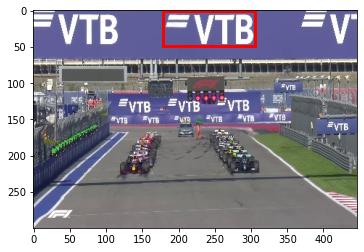

In [64]:
#original
#im = cv2.imread(str(data.values[2][-2]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, data.values[2][-2])

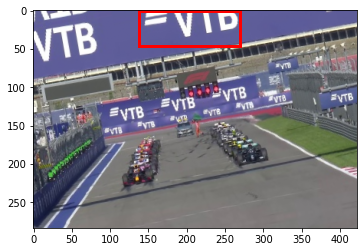

In [39]:

# after transformation
im, bb = transformsXY(str(data.values[2][8]),data.values[2][9],True )
show_corner_bb(im, bb)